Explain this

In [1]:
# load MDAnalysis library 
# to deal with GRO/XTC files
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

# arrays
import numpy as np

# machine learning
from sklearn.decomposition import PCA, KernelPCA

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

start

In [2]:
# define path to structure files
PATHD = "../datasets/trajectories/"
FRAME = PATHD + "CLCec1_anton2_restrained_15us.gro"
TRAJ1 = PATHD + "CLCec1_anton2_restrained_15us.xtc"
TRAJ2 = PATHD + "CLCec1_anton2_unrestrain_15us.xtc"

# load traj files
rest = mda.Universe(FRAME,TRAJ1)
unrs = mda.Universe(FRAME,TRAJ2)
#trj = mda.Universe(FRAME,[TRAJ1,TRAJ2])

Ramachandran analysis
----------------------------

Let's compare both trajectories using a simple dihedral analysis, no fitting requiered

In [3]:
# select protein residues
restrained = rest.select_atoms("protein and resid 2-429")
unrestrain = unrs.select_atoms("protein and resid 2-429")

# quick calculation of phi and psi angles
R = Ramachandran(restrained).run()
U = Ramachandran(unrestrain).run()

plotting

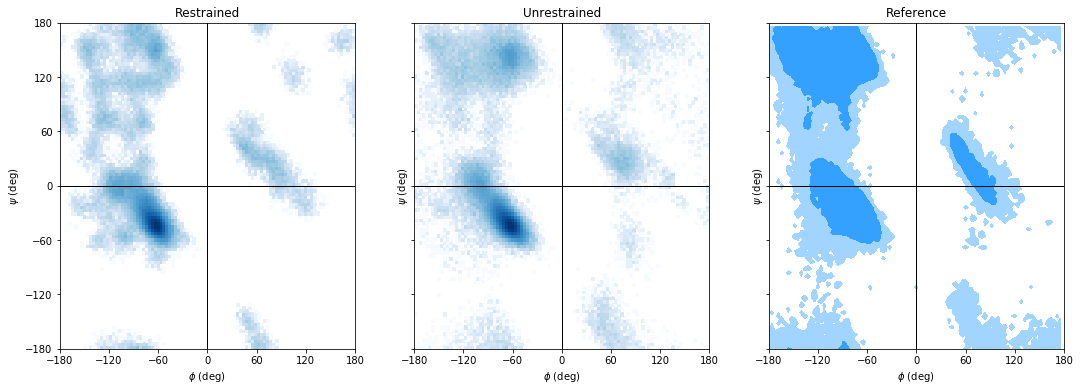

In [4]:
# create a figure and three subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')
axes[2].title.set_text('Reference')
    
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# plot backbone dihedral maps for all frames
axes[0].hist2d(r[:,0], r[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(u[:,0], u[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

# plot reference map which shows allowed and marginally allowed regions
U.plot(ax=axes[2], color='k', marker=".", alpha=0.0, ref=True)

the **Unrestrained** is more flexible, as expected, but also more similar to the **Reference** map. 
At least for me, in a qualitative way. 

Dihedral PCA
----------------

Let's compare the 2 trajectories!

In [9]:
# fitting
#ref = mda.Universe(FRAME)
#fit = align.AlignTraj(trj, ref, select="protein and name CA", in_memory=True)
#fit.run()

In [10]:
# select only calpha carbons
protein = trj.select_atoms("name CA")

# get cartesian positions for traj1 and 2
trajCA = np.array([protein.positions for ts in trj.trajectory])

In [11]:
# scikit-learn expects 2d numpy arrays
# for the training dataset
frames, atoms, dimensions = trajCA.shape
# change dimensions
dataset = trajCA.reshape((frames,atoms*dimensions))

# get PCA projection 
pca = PCA(n_components=2)
vec = pca.fit(dataset).transform(dataset)

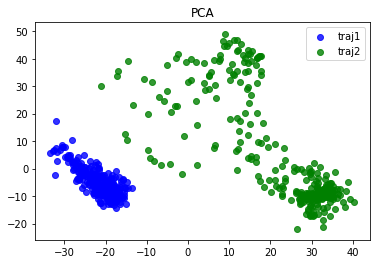

In [12]:
# plot
plt.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

In [13]:
kpca = KernelPCA(kernel="cosine", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(dataset)

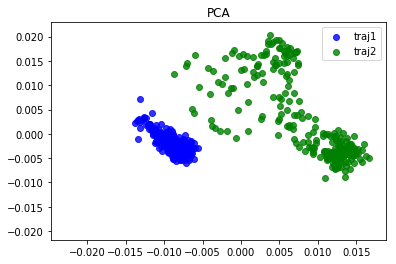

In [14]:
# plot
plt.scatter(X_kpca[:300,0], X_kpca[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(X_kpca[300:,0], X_kpca[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()